# Example: Single Pendulum solved by [Uniform grid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).

A simple pendulum is a typical example of a nonlinear dynamical system.
The pendulum's state is represented by its angular position ($x_1$ in radians) and angular velocity ($x_2$ in radians per second), and it is influenced by
gravitational forces ($g$ in meter per squared second), the length of the pendulum ($l$ in meter) and an external control input ($u$) that is a torque/force applied to modulate its behavior.
The objective is to drive the pendulum from a specified initial state (near the stable downward position)
to a target state (near the upright position), respecting constraints on both the state variables and the control input.

The dynamics of the pendulum are given by:
$$
\begin{align}
\dot{x}_1 & = x_2\\
\dot{x}_2 & = -\frac{g}{l} \sin(x_1) + u
\end{align}
$$

Considering this as a reachability problem, we will use it to showcase the capabilities of the Uniform grid abstraction solving typical problem in Dionysos.
The initial and target sets are defined as intervals in the state space.

$$
\begin{align}
x_{1,\text{initial}} & = \frac{5.0 × \pi}{180.0}[-1.0, 1.0]\\
x_{2,\text{initial}} & = 0.5 × [-1.0, 1.0]\\
x_{1,\text{target}} & = \pi + \frac{5.0 × \pi}{180.0}[-1.0, 1.0]\\
x_{2,\text{target}} & = [-1.0, 1.0]
\end{align}
$$

First, let us import [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) and [Plots](https://github.com/JuliaPlots/Plots.jl).

In [1]:
using StaticArrays, Plots

At this point, we import Dionysos and JuMP.

In [2]:
using Dionysos, JuMP

Define the problem using JuMP
We first create a JuMP model:

In [3]:
model = Model(Dionysos.Optimizer)

A JuMP Model
├ solver: unknown
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

Define the discretization step

In [4]:
hx = 0.05
l = 1.0
g = 9.81

9.81

Define the state variables: x1(t), x2(t)

In [5]:
x_low, x_upp = [-π, -10.0], [π + pi, 10.0]
@variable(model, x_low[i] <= x[i = 1:2] <= x_upp[i])
nothing #hide

Define the control variables: $u_1(t)$, $u_2(t)$

In [6]:
@variable(model, -3.0 <= u <= 3.0)

u

Define the dynamics

In [7]:
@constraint(model, ∂(x[1]) == x[2])
@constraint(model, ∂(x[2]) == -(g / l) * sin(x[1]) + u)

∂(x[2]) - ((-9.81 * sin(x[1])) + u) = 0

Define the initial and target sets

In [8]:
x1_initial, x2_initial = (5.0 * pi / 180.0) .* [-1, 1], 0.5 .* [-1, 1]
x1_target, x2_target = pi .+ (5.0 * pi / 180.0) .* [-1, 1], 1.0 .* [-1, 1]

@constraint(model, start(x[1]) in MOI.Interval(x1_initial...))
@constraint(model, start(x[2]) in MOI.Interval(x2_initial...))

@constraint(model, final(x[1]) in MOI.Interval(x1_target...))
@constraint(model, final(x[2]) in MOI.Interval(x2_target...))

final(x[2]) ∈ [-1, 1]

### Definition of the abstraction

Definition of the grid of the state-space on which the abstraction is based (origin `x0` and state-space discretization `h`):

We define the growth bound function of $f$:

In [9]:
function jacobian_bound(u)
    return SMatrix{2, 2}(0.0, 1.0, (g / l), 0)
end
set_attribute(model, "jacobian_bound", jacobian_bound)

set_attribute(model, "time_step", 0.1)

x0 = SVector(0.0, 0.0);
h = SVector(hx, hx);
set_attribute(model, "state_grid", Dionysos.Domain.GridFree(x0, h))

Definition of the grid of the input-space on which the abstraction is based (origin `u0` and input-space discretization `h`):

In [10]:
u0 = SVector(0.0);
h = SVector(0.3);
set_attribute(model, "input_grid", Dionysos.Domain.GridFree(u0, h))

Solving the problem

In [11]:
optimize!(model)

>>Setting up the model
>>Model setup complete
┌ Warning: Noise is not yet accounted for in system abstraction.
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/2ZeUN/src/optim/abstraction/UniformGridAbstraction/empty_problem.jl:393
compute_abstract_system_from_concrete_system!: started with Dionysos.System.DiscreteTimeGrowthBound
compute_abstract_system_from_concrete_system! terminated with success: 9402115 transitions created
┌ Warning: The `state_cost` is not yet fully implemented
└ @ Dionysos.Optim.Abstraction.UniformGridAbstraction ~/.julia/packages/Dionysos/2ZeUN/src/optim/abstraction/UniformGridAbstraction/optimal_control_problem.jl:226
compute_controller_reachability! started

 Reachability: terminated with true


Get the results

In [12]:
abstract_system = get_attribute(model, "abstract_system");
abstract_problem = get_attribute(model, "abstract_problem");
abstract_controller = get_attribute(model, "abstract_controller");
concrete_controller = get_attribute(model, "concrete_controller")
concrete_problem = get_attribute(model, "concrete_problem");
concrete_system = concrete_problem.system;
abstract_value_function = get_attribute(model, "abstract_value_function");

### Trajectory display

In [13]:
nstep = 100
function reached(x)
    if x ∈ concrete_problem.target_set
        return true
    else
        return false
    end
end
x0 = SVector(Dionysos.Utils.sample(concrete_problem.initial_set)...)
control_trajectory = Dionysos.System.get_closed_loop_trajectory(
    get_attribute(model, "discrete_time_system"),
    concrete_controller,
    x0,
    nstep;
    stopping = reached,
)

using Plots

Here we display the coordinate projection on the two first components of the state space along the trajectory.

In [14]:
fig = plot(; aspect_ratio = :equal);

We display the concrete domain

In [15]:
plot!(concrete_system.X; color = :grey, label = "");

We display the specifications

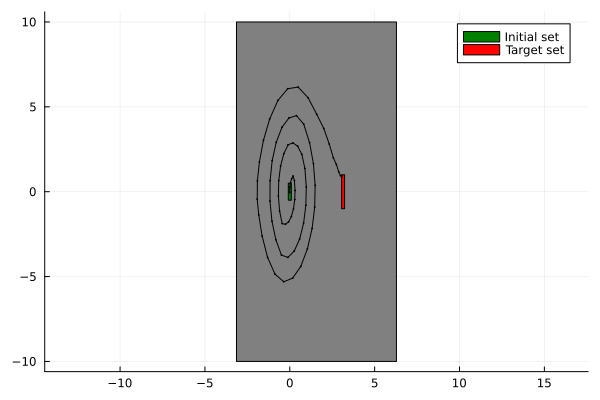

In [16]:
plot!(concrete_problem.initial_set; color = :green, opacity = 1.0, label = "Initial set");
plot!(concrete_problem.target_set; color = :red, opacity = 1.0, label = "Target set");
plot!(control_trajectory; markersize = 1, arrows = false)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*